In [1]:
#http://physics.ucsc.edu/~peter/242/numerov.pdf

# Relevant Imports and Matplotlib Settings

import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
import numpy as np
import math

fig_width = 15
fig_height = 10

print("Figure width: " + str(fig_width))
print("Figure height: " + str(fig_height))
print("Import and Setup Complete")


Figure width: 15
Figure height: 10
Import and Setup Complete


In [2]:
# Constants and Global Variables

hbar       = 1.05457e-34     # Planck's Constant / 2pi
m_rest     = 9.10938356e-31  # Mass of electron (Kg)
m          = m_rest*0.41    # Effective mass of electron
e          = -1.6e-19        # Charge of electron (Coulombs)
Efield     = 1e4             # Field Strength across well (Vm-1)
well_dim   = [0,100e-10]        # Start and endpoints of well (m)
well_width = well_dim[1]-well_dim[0]

# Initial Values

psi_0 = 0
psi_1 = 100

# Per-Run Settings

potential_type = "field" #'zero', 'constant', 'field'
num_steps = 1000

In [3]:
# Helper Functions

# Assume that the wavefunction is confined to a well of size 1. Scale all appropriately
def x_to_unscaled(x_scaled):
    return x*well_width

def step_width():
    return well_width/num_steps

def current_x(step):
    return step_width()*step

def calc_potential(x_unscaled):
    if potential_type == "zero": return 0
    if potential_type == "constant":
        return e*Efield
    if potential_type == "field":
        return e*Efield*(x_unscaled) - e*Efield*well_width/2
    
def calc_ksq(x_unscaled,energy):
    return (2*m/hbar**2)*(energy-calc_potential(x_unscaled))
    #return 0.25

def scale_list(in_list, scale_factor):
    return list(map((lambda x: x*scale_factor), in_list))

def plot_psi(x_list, psi_list):
    plt.plot(x_list, psi_list, linestyle='None', marker='+')
    plt.show
    
def calc_x_coeff(energy):
    return math.sqrt(2*m*energy/well_width**2)

def calc_1d_coeff(energy):
    return 2*m*energy/hbar**2

def energy_to_frequency(energy):
    return 2*math.pi*hbar*3e8/energy

In [4]:
# Next Step Logic and Full Wavefunction Computation
# See equation 12: http://physics.ucsc.edu/~peter/242/numerov.pdf

def psi_next(psi_curr, psi_prev, step, energy):
    # simple arguments
    h = step_width()
    hsq = h**2
    x = current_x(step)
    ksq_next = calc_ksq(x, energy)
    #print(ksq_next)
    ksq_curr = calc_ksq(x-step_width(), energy)
    ksq_prev = calc_ksq(x-2*step_width(), energy)
    
    # splitting next step equation into three terms
    numerator_t1 = 2*(1-(5/12)*hsq*ksq_curr)*psi_curr
    
    numerator_t2 = -1*(1+(1/12)*hsq*ksq_prev)*psi_prev
    denominator  = 1+(1/12)*hsq*ksq_next
    
    # full psi term
    psi_next = (numerator_t1+numerator_t2)/denominator
    
    # return arguments for next psi calculation
    return psi_next, psi_curr, step+1, energy


def psi_full(energy):
    psi_curr = psi_1
    psi_prev = psi_0
    
    psi_list = [psi_prev, psi_curr]
    x_list   = [0,1]
    
    for step in range(2,num_steps):
        psi_data = psi_next(psi_curr, psi_prev, step, energy)
        psi_curr = psi_data[0]
        psi_prev = psi_data[1]
        #print("delta " + str(psi_curr-psi_prev))
        psi_list.append(psi_curr)
        x_list.append(step)
        #plot_psi(scale_list(x_list, step_width()), psi_list)
        
    x_list = scale_list(x_list, step_width())
    
    # Normalizing the wavefunction
    total_integral = 0
    step_size = step_width()
    for psi in psi_list:
        total_integral += psi*psi*step_size

    # Normalization coefficient
    norm_coeff = math.sqrt(1/total_integral)
    
    # Applying normalization
    normalized_psi_list = []
    for psi in psi_list:
        normalized_psi_list.append(psi*norm_coeff)
    
    
    return x_list, normalized_psi_list

def overlap_integral(x_list, psi_list1, psi_list2):
    # calculates the numerical overlap integral between two wavefunctions
    # two psi_lists must have same spacing and total well length
    step_width = x_list[1]-x_list[0]
    total_integral = 0
    for i in range(len(x_list)):
        total_integral += step_width*psi_list1[i]*psi_list2[i]
    return total_integral

In [5]:
# Optimization

# Returns [number of zero crossings, delta between last element and 0]
def optimization_wrapper(energy):
    # Collecting wavefunction data
    x_list, psi_list = psi_full(energy)
    
    # Searching for zero crossings
    num_zero_crossings = 0
    for i in range(5, len(x_list)-5): #not capturing endpoints
        if ((psi_list[i] > 0) != (psi_list[i+1] > 0)):
            num_zero_crossings += 1
            #print("###ZERO FOUND at x=" + str(x_list[i]))
    
    # Finding delta
    delta = psi_list[-1]
    
    return num_zero_crossings, delta

def optimization_wrapper_scipy(energy_arr):
    return optimization_wrapper(energy_arr[0])[1]

# Optimizes using the SciPy toolkit
# This doesn't work due to fixed-point issues
def optimize_scipy(energy_guess):
    result = scipy.optimize.minimize(optimization_wrapper_scipy, [energy_guess])
    if result.success:
        fitted_params = result.x
        print("fitted: " + str(fitted_params))
        print("minimized offset: " + str(optimization_wrapper(fitted_params)))
        return fitted_params
    else:
        raise ValueError(result.message)

# Searches for eigenvalue solutions with energy greater than energy_start
def optimize_custom(energy_start, step_start, iterations):
    print("     mass " + str(m))
    print("     efield " + str('%e'%Efield))
    energy = energy_start
    step_size  = step_start
    zeroes, delta = optimization_wrapper(energy)
    deltagzero = (delta > 0)
    for i in range(iterations):
        zeroes, delta = optimization_wrapper(energy)
        #print("deltagzero " + str(deltagzero))
        #print("delta>0 " + str(delta>0))
        #print("delta " + str(delta))
        #x, psi = psi_full(energy)
        #plt.plot(x, psi, alpha=1)
        # If this has caused a sign change in delta, we have passed the next energy state
        # Move back and half the step size
        if ((delta>0) != deltagzero):
            #print("^zero detected^")
            energy -= step_size
            #energy += step_size
            step_size /= 2
        # Otherwise, increment energy
        else:
            energy += step_size
        plt.show()
    return energy, delta, zeroes
    
        
    
        

In [6]:
# Finding consecutive energy eigenvalues, and all possible transitions

def find_energy_evals(energy_start, iterations_start, eval_num_list):
    energy_eval_list = []
    energy_delta_list = []
    energy_zeroes_list = []
    num_zeroes = 0
    iterations = iterations_start
    energy = energy_start
    for eval_num in eval_num_list:
        #note: eval = 1+num_zeroes
        zero_found = False
        step_size = energy/4
        #print("Searching for eigenvalue " + str(eval_num))
        while (not zero_found):
            energy_new, delta, zeroes = optimize_custom(energy, energy/4, iterations)
            print("eigenvalue desired: " + str(eval_num) + " eigenvalue found: " + str(zeroes+1))
            print("    energy start: " + str(energy) + " optimized energy: " + str(energy_new))
            if energy > 0: energy = energy_new*0.9
            else: energy = energy_new*1.1
            x_list, psi_list = psi_full(energy_new)
            plt.plot(x_list, psi_list)
            plt.show()
            print("zeroes " + str(zeroes))
            if (zeroes + 1 == eval_num):
                if energy > 0: energy *= 1.2
                else: energy *= 0.8
                energy_eval_list.append(energy_new)
                energy_delta_list.append(delta)
                energy_zeroes_list.append(zeroes)
                zero_found = True
                print("Found energy eigenval " + str(zeroes+1) + " at " + str(energy_new))
            elif zeroes + 1 > eval_num:
                print("    No eigenval "  +str(eval_num) + " found. Energy too high!")
                zero_found = True
            else:
                step_size *= 2
    return energy_zeroes_list, energy_eval_list, energy_delta_list

# Finding absorption bands
def find_absorption_bands(energy_eval_list):
    possible_absorptions = []
    for e1 in energy_eval_list:
        for e2 in energy_eval_list:
            if (e1 != e2 and e1 - e2 > 0):
                possible_absorptions.append(energy_to_frequency(e1-e2)*1e9)
    return possible_absorptions

# Generating absorption - voltage data
def generate_energies_voltages(energy_start, iterations_start, num_evals, num_fstrengths):
    eval_nums     = list(range(num_evals))
    fstrength_exps  = list(range(num_fstrengths))
    fstrengths      = list(map((lambda x: 1*10**x), fstrength_exps))
    fstrength_points = []
    absorption_points = []
    
    for fstrength in fstrengths:
        global Efield 
        Efield = fstrength
        energy_zeroes_list, energy_eval_list, energy_delta_list = find_energy_evals(energy_start, iterations_start, eval_nums)
        possible_absorptions = find_absorption_bands(energy_eval_list)
        absorption_points += possible_absorptions
        fstrength_points += [fstrength]*len(possible_absorptions)
    plt.plot(fstrength_points, absorption_points, linestyle='None', marker='+')
    plt.ylim(min(absorption_points)-0.1, max(absorption_points)+0.1)
    plt.grid()
    plt.xscale("log")
    plt.yscale("log")
    plt.show()
    
    


In [7]:
# Finding first energy level -> first energy level transitions for GaAs
gaas_band_gap_ev = 1.43 #http://hyperphysics.phy-astr.gsu.edu/hbase/Tables/Semgap.html
gaas_band_gap    = gaas_band_gap_ev*1.6e-19

electron_charge  = -1.6e-19
electron_mass    =  9.10938356e-31  # Mass of electron (Kg)
effective_electron_mass = 0.067*electron_mass # https://ecee.colorado.edu/~bart/book/effmass.htm
effective_hole_mass = 0.45*electron_mass # https://ecee.colorado.edu/~bart/book/effmass.htm

def find_first_transition_energy(energies_start_electron, energies_start_hole, num_iterations, fstrengths, graphs):
    hole_eigenvals = []
    electron_eigenvals = []
    overlap_integrals = []
    global m
    global Efield
    global e
    # For each iteration, find first energy eigenstates of hole and electron
    for fstrength in fstrengths:
        print("FINDING ENERGIES FOR FSTRENGTH " + str('%e'%fstrength))
        i_curr = fstrengths.index(fstrength)
        energy_start_electron = energies_start_electron[i_curr]
        energy_start_hole = energies_start_hole[i_curr]
        # Finding electron energy
        # Setting mass and field strength
        m = effective_electron_mass
        Efield = fstrength
        e = electron_charge
        # Finding first energy level
        print("   Testing electron energy " + str(energy_start_electron))
        energy, delta, zeroes = optimize_custom(energy_start_electron, energy_start_electron/4, num_iterations)
        if (zeroes > 0):
            print("   Num zeroes " + str(zeroes))
            print("   Failed to find electron energy")
        else:
            electron_eigenvals.append(energy)
            print("   Electron energy " + str(energy))
        x_list, psi_list_electron = psi_full(energy)

        # Finding hole energy
        # Setting mass and field strength
        m = effective_hole_mass
        Efield = fstrength
        e = -electron_charge
        # Finding first energy level
        print("   Testing hole energy " + str(energy_start_hole))
        energy, delta, zeroes = optimize_custom(energy_start_hole, energy_start_hole/4, num_iterations)
        if (zeroes > 0): 
            print("   Num zeroes " + str(zeroes))
            print("   Failed to find hole energy")
        else:
            hole_eigenvals.append(energy)
            print("   Hole energy " + str(energy))
        x_list, psi_list_hole = psi_full(energy)
              
        if graphs:
            labels = ["Electron Wavefunction", "Hole Wavefunction"]
            lines = []
            eline, = plt.plot(x_list, psi_list_electron, c='black', linestyle="--", label = labels[0])
            hline, = plt.plot(x_list, psi_list_hole, c='black', linestyle=":", label = labels[1])
            lines.append(eline)
            lines.append(hline)
            plt.legend(lines, labels,loc=8)
            plt.xlabel("Position")
            #plt.ylabel("Potential")
            plt.yticks([])
            plt.xticks([])
            plt.title("Hole-Electron Overlap for Efield=" + str('%e'%Efield) + " Vm-1")
            plt.show()
            
        overlap_integral_val = overlap_integral(x_list, psi_list_electron, psi_list_hole)
        print("   Overlap: " + str(overlap_integral_val))
        overlap_integrals.append(overlap_integral_val)
    
    # Now finding energy differences
    if (len(hole_eigenvals) != len(electron_eigenvals)):
        print("len electron eigenvals " + str(len(electron_eigenvals)))
        print("len hole eigenvals " + str(len(hole_eigenvals)))
        print("\nenergy_start too high. Exiting...")
        return [-1], [-1], [-1], [-1];
    
    print("\nFINDING TRANSITION ENERGIES")
    transition_energies = []
    transition_energies_nm = []
    transition_energies_ev = []
    for i in range(len(hole_eigenvals)):
        transition_energies.append(electron_eigenvals[i]+hole_eigenvals[i]+gaas_band_gap)
        print("Transition Energy for Voltage " + str('%e'%fstrengths[i]) + ": " + str(transition_energies[-1]))
        transition_energies_nm.append(energy_to_frequency(transition_energies[-1])*1e9)
        print("  In nm: " + str(transition_energies_nm[-1]))
        transition_energies_ev.append(transition_energies[-1]/(1.6e-19))
        print("  In eV: " + str(transition_energies_ev[-1]))
    
    return fstrengths, transition_energies, transition_energies_nm, transition_energies_ev, overlap_integrals, electron_eigenvals, hole_eigenvals

FINDING ENERGIES FOR FSTRENGTH 1.000000e+06
   Testing electron energy 1e-21
     mass 6.1032869852e-32
     efield 1.000000e+06
   Electron energy 9.007750439507209e-21
   Testing hole energy 1e-22
     mass 4.099222602e-31
     efield 1.000000e+06
   Hole energy 1.3201244296217274e-21


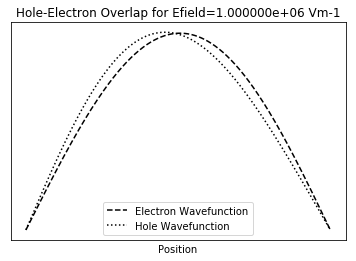

   Overlap: 0.9966476128250339
FINDING ENERGIES FOR FSTRENGTH 2.000000e+06
   Testing electron energy 1e-21
     mass 6.1032869852e-32
     efield 2.000000e+06
   Electron energy 8.99934082229246e-21
   Testing hole energy 1e-22
     mass 4.099222602e-31
     efield 2.000000e+06
   Hole energy 1.2582917175924835e-21


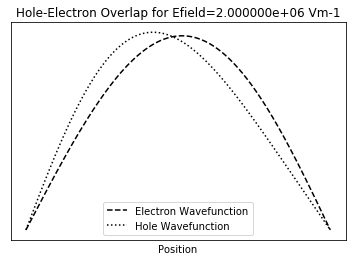

   Overlap: 0.9868933771699452
FINDING ENERGIES FOR FSTRENGTH 3.000000e+06
   Testing electron energy 1e-21
     mass 6.1032869852e-32
     efield 3.000000e+06
   Electron energy 8.984799066277758e-21
   Testing hole energy 1e-22
     mass 4.099222602e-31
     efield 3.000000e+06
   Hole energy 1.1578784985433462e-21


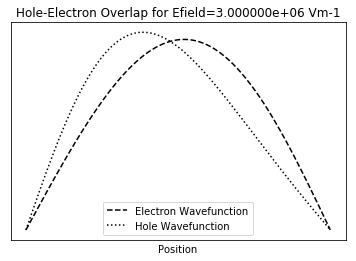

   Overlap: 0.9715607748821623
FINDING ENERGIES FOR FSTRENGTH 4.000000e+06
   Testing electron energy 1e-21
     mass 6.1032869852e-32
     efield 4.000000e+06
   Electron energy 8.964136544572216e-21
   Testing hole energy 1e-22
     mass 4.099222602e-31
     efield 4.000000e+06
   Hole energy 1.0216596204750867e-21


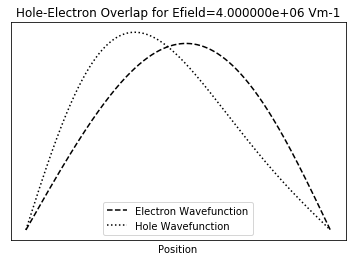

   Overlap: 0.9517837327914727
FINDING ENERGIES FOR FSTRENGTH 5.000000e+06
   Testing electron energy 1e-21
     mass 6.1032869852e-32
     efield 5.000000e+06
   Electron energy 8.937369107914378e-21
   Testing hole energy 1e-22
     mass 4.099222602e-31
     efield 5.000000e+06
   Hole energy 8.528985328974443e-22


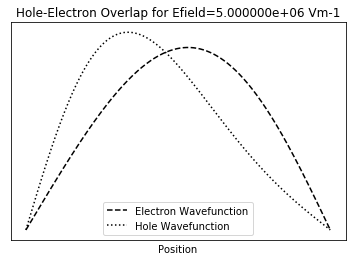

   Overlap: 0.9287712841645557
FINDING ENERGIES FOR FSTRENGTH 6.000000e+06
   Testing electron energy 1e-21
     mass 6.1032869852e-32
     efield 6.000000e+06
   Electron energy 8.904517014032661e-21
   Testing hole energy 1e-22
     mass 4.099222602e-31
     efield 6.000000e+06
   Hole energy 6.54984857398956e-22


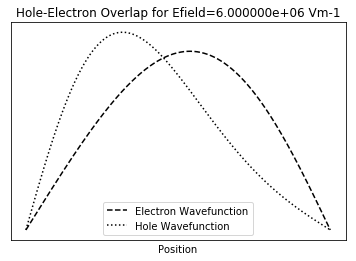

   Overlap: 0.9036294725259508
FINDING ENERGIES FOR FSTRENGTH 7.000000e+06
   Testing electron energy 1e-21
     mass 6.1032869852e-32
     efield 7.000000e+06
   Electron energy 8.865604838211046e-21
   Testing hole energy 1e-22
     mass 4.099222602e-31
     efield 7.000000e+06
   Hole energy 4.31174487822513e-22


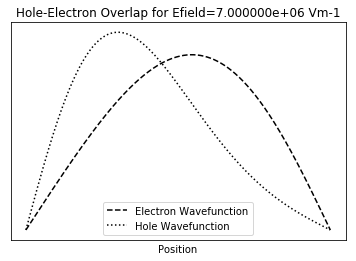

   Overlap: 0.8772690709826759
FINDING ENERGIES FOR FSTRENGTH 8.000000e+06
   Testing electron energy 1e-21
     mass 6.1032869852e-32
     efield 8.000000e+06
   Electron energy 8.820661365711079e-21
   Testing hole energy 1e-22
     mass 4.099222602e-31
     efield 8.000000e+06
   Hole energy 1.8444040834793245e-22


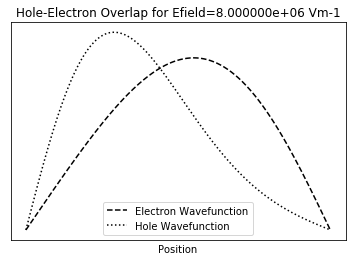

   Overlap: 0.8503846884856789
FINDING ENERGIES FOR FSTRENGTH 9.000000e+06
   Testing electron energy 1e-21
     mass 6.1032869852e-32
     efield 9.000000e+06
   Electron energy 8.769719467556446e-21
   Testing hole energy -1e-23
     mass 4.099222602e-31
     efield 9.000000e+06
   Hole energy -8.258891398865091e-23


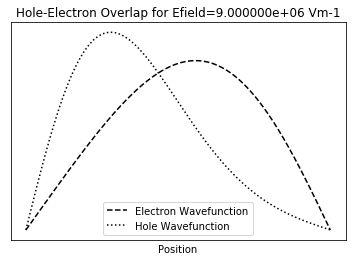

   Overlap: 0.8234758104542919

FINDING TRANSITION ENERGIES
Transition Energy for Voltage 1.000000e+06: 2.3912787486912893e-19
  In nm: 831.2780849600305
  In eV: 1.4945492179320559
Transition Energy for Voltage 2.000000e+06: 2.3905763253988494e-19
  In nm: 831.5223394869272
  In eV: 1.494110203374281
Transition Energy for Voltage 3.000000e+06: 2.389426775648211e-19
  In nm: 831.9223836765
  In eV: 1.4933917347801318
Transition Energy for Voltage 4.000000e+06: 2.387857961650473e-19
  In nm: 832.4689536574217
  In eV: 1.4924112260315456
Transition Energy for Voltage 5.000000e+06: 2.3859026764081183e-19
  In nm: 833.1511752232465
  In eV: 1.4911891727550741
Transition Energy for Voltage 6.000000e+06: 2.383595018714316e-19
  In nm: 833.9577836044979
  In eV: 1.4897468866964476
Transition Energy for Voltage 7.000000e+06: 2.3809677932603353e-19
  In nm: 834.877995596795
  In eV: 1.4881048707877096
Transition Energy for Voltage 8.000000e+06: 2.37805101774059e-19
  In nm: 835.9020071429578
  

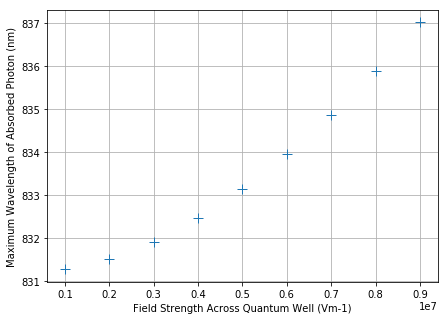

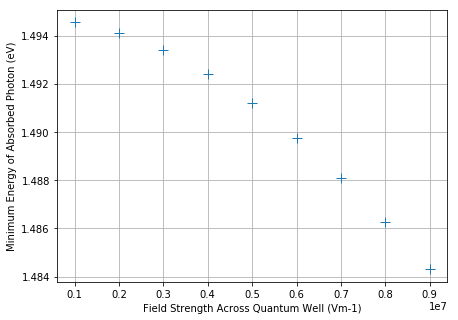

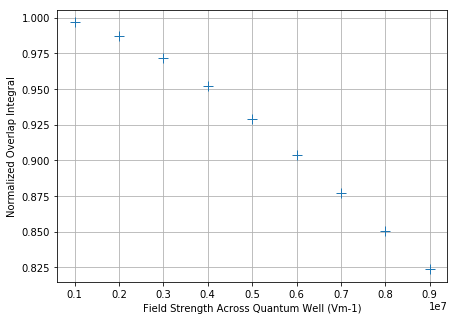

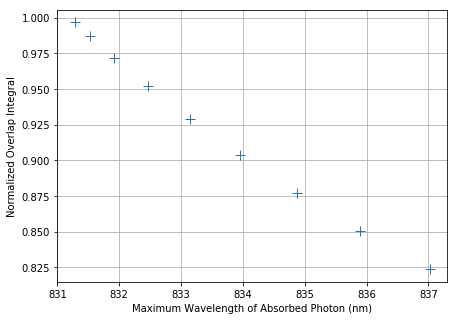

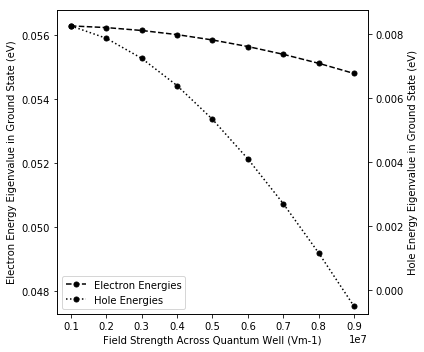

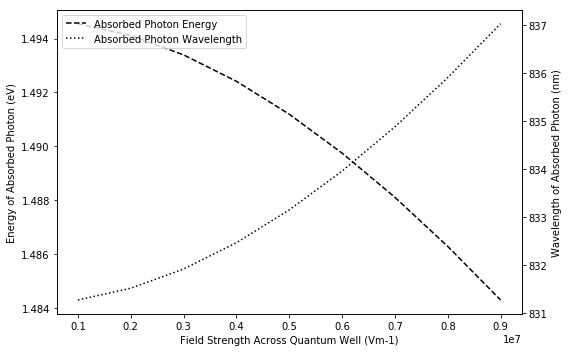

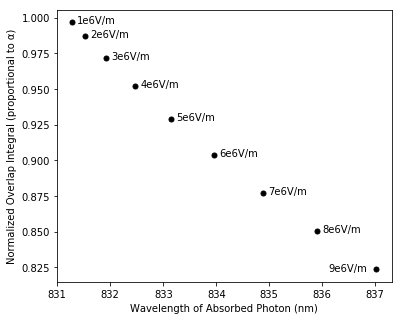

In [11]:
#general testing

#print("\n###ABSORPTION WAVELENGTH CUMULATIVE TESTING###")
#generate_energies_voltages(energy_eigenval, 100, 10, 5)

#energies_start_electron = [1e-21]*7+[1e-22, -5e-20,-1.2e-18,-1.2e-17]
#energies_start_hole     = [1e-21]*6+[1e-22,-5e-21,-1e-19,-1.2e-18,-1.2e-17]

#fstrengths_input = [0, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
#fstrengths_input = [1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7,1e8,1e9,1e10]

#1e7 fields
#fstrengths_input = [1e7,2e7,3e7,4e7,5e7,6e7,7e7,8e7,9e7]
#energies_start_hole = [-1e-22,-1e-22,-1e-21,-1e-21,-1e-20,-1e-20,-1e-20,-2e-20,-3e-20]
#energies_start_electron = [1e-21,1e-21,1e-21,1e-21,1e-21,-1e-22,-1e-22,-1e-21,-1e-21]

#1e6 fields
fstrengths_input = [1e6,2e6,3e6,4e6,5e6,6e6,7e6,8e6,9e6]
energies_start_hole = [1e-22,1e-22,1e-22,1e-22,1e-22,1e-22,1e-22,1e-22,-1e-23]
energies_start_electron = [1e-21,1e-21,1e-21,1e-21,1e-21,1e-21,1e-21,1e-21,1e-21]

fstrengths, transition_energies, transition_energies_nm, transition_energies_ev, overlaps, electron_evals, hole_evals = find_first_transition_energy(energies_start_electron, energies_start_hole, 200, fstrengths_input, True)
#print(fstrengths)
#print(transition_energies_ev)

plt.figure(figsize=(7,5))
plt.plot(fstrengths, transition_energies_nm,linestyle='None', marker='+', markersize=10)
#plt.plot(np.unique(fstrengths), np.poly1d(np.polyfit(fstrengths, transition_energies_nm, 1))(np.unique(fstrengths)))
plt.xlabel("Field Strength Across Quantum Well (Vm-1)")
plt.ylabel("Maximum Wavelength of Absorbed Photon (nm)")
#plt.xscale("log")
#plt.yscale("log"
plt.grid()
plt.show()

plt.figure(figsize=(7,5))
plt.plot(fstrengths, transition_energies_ev,linestyle='None', marker='+', markersize=10)
#plt.plot(np.unique(fstrengths), np.poly1d(np.polyfit(fstrengths, transition_energies_ev, 1))(np.unique(fstrengths)))
plt.xlabel("Field Strength Across Quantum Well (Vm-1)")
plt.ylabel("Minimum Energy of Absorbed Photon (eV)")
#plt.xscale("log")
#plt.yscale("log")
plt.grid()
plt.show()

plt.figure(figsize=(7,5))
plt.plot(fstrengths, overlaps,linestyle='None', marker='+', markersize=10)
#plt.plot(np.unique(fstrengths), np.poly1d(np.polyfit(fstrengths, overlaps, 1))(np.unique(fstrengths)))
plt.xlabel("Field Strength Across Quantum Well (Vm-1)")
plt.ylabel("Normalized Overlap Integral")
#plt.xscale("log")
#plt.yscale("log")
plt.grid()
plt.show()

plt.figure(figsize=(7,5))
plt.plot(transition_energies_nm, overlaps,linestyle='None', marker='+', markersize=10)
#plt.plot(np.unique(fstrengths), np.poly1d(np.polyfit(fstrengths, overlaps, 1))(np.unique(fstrengths)))
plt.xlabel("Maximum Wavelength of Absorbed Photon (nm)")
plt.ylabel("Normalized Overlap Integral")
#plt.xscale("log")
#plt.yscale("log")
plt.grid()
plt.show()

#plt.figure(figsize=(5,5))
#electron_evals = scale_list(electron_evals, 1/1.6e-19)
#hole_evals = scale_list(hole_evals, 1/1.6e-19)
#lines = []
#labels = ["Electron Energies", "Hole Energies"]
#eline, = plt.plot(fstrengths, electron_evals,linestyle='--', marker='.', markersize=10, c='black')
#hline, = plt.plot(fstrengths, hole_evals,linestyle=':', marker='.', markersize=10, c='black')
#lines.append(eline)
#lines.append(hline)
#plt.plot(np.unique(fstrengths), np.poly1d(np.polyfit(fstrengths, overlaps, 1))(np.unique(fstrengths)))
#plt.xlabel("Field Strength Across Quantum Well (Vm-1)")
#plt.ylabel("Energy Eigenvalue in Ground State (eV)")
#plt.xscale("log")
#plt.yscale("log")
#plt.grid()
#plt.legend(lines, labels)
#plt.show()

#eigenvalues
fig, ax1 = plt.subplots()
fig.set_size_inches(6, 5)
lines = []
labels = ["Electron Energies", "Hole Energies"]
electron_evals = scale_list(electron_evals, 1/1.6e-19)
hole_evals = scale_list(hole_evals, 1/1.6e-19)

ax1.set_xlabel('Field Strength Across Quantum Well (Vm-1)')
ax1.set_ylabel('Electron Energy Eigenvalue in Ground State (eV)')
eline, = ax1.plot(fstrengths, electron_evals, linestyle='--', marker='.', markersize=10, c='black')
ax1.tick_params(axis='y')
ax1.set_ylim([max(electron_evals)-0.009, max(electron_evals)+0.0005])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Hole Energy Eigenvalue in Ground State (eV)')  # we already handled the x-label with ax1
hline, = ax2.plot(fstrengths, hole_evals, linestyle=':', marker='.', markersize=10, c='black')
ax2.tick_params(axis='y')
ax2.set_ylim([max(hole_evals)-0.009, max(hole_evals)+0.0005])


lines.append(eline)
lines.append(hline)

plt.legend(lines,labels,loc=3)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


#transition energy in nm and ev plot
fig, ax1 = plt.subplots()
fig.set_size_inches(8, 5)
lines = []
labels = ["Absorbed Photon Energy", "Absorbed Photon Wavelength"]

ax1.set_xlabel('Field Strength Across Quantum Well (Vm-1)')
ax1.set_ylabel('Energy of Absorbed Photon (eV)')
eline, = ax1.plot(fstrengths, transition_energies_ev, linestyle='--', marker='None', markersize=10, c='black')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Wavelength of Absorbed Photon (nm)')  # we already handled the x-label with ax1
hline, = ax2.plot(fstrengths, transition_energies_nm, linestyle=':', marker='None', markersize=10, c='black')
ax2.tick_params(axis='y')

lines.append(eline)
lines.append(hline)

plt.legend(lines,labels)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


fig, ax1 = plt.subplots()
fig.set_size_inches(6, 5)
plt.plot(transition_energies_nm, overlaps,linestyle='None', marker='.', markersize=10, c='black')
#plt.plot(np.unique(fstrengths), np.poly1d(np.polyfit(fstrengths, overlaps, 1))(np.unique(fstrengths)))
plt.xlabel("Wavelength of Absorbed Photon (nm)")
plt.ylabel("Normalized Overlap Integral (proportional to α)")

pointlabels = ["1e6V/m","2e6V/m","3e6V/m","4e6V/m","5e6V/m","6e6V/m","7e6V/m","8e6V/m","9e6V/m",]
for i in range(len(transition_energies_nm)):
    if i == len(transition_energies_nm)-1:
            plt.text(transition_energies_nm[i]-0.9, overlaps[i]-.001, pointlabels[i])
    else: plt.text(transition_energies_nm[i]+0.1, overlaps[i]-.001, pointlabels[i])
#plt.ylim([0,1])
#plt.xlim([825,840])
plt.show()



Text(0, 0.5, 'value')

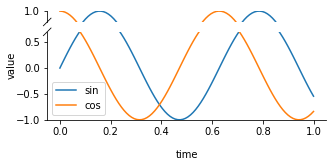

In [18]:
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes
import numpy as np

fig = plt.figure(figsize=(5,2))
bax = brokenaxes(ylims=((-1, .7), (.79, 1)))
x = np.linspace(0, 1, 100)
bax.plot(x, np.sin(10 * x), label='sin')
bax.plot(x, np.cos(10 * x), label='cos')
bax.legend(loc=3)
bax.set_xlabel('time')
bax.set_ylabel('value')

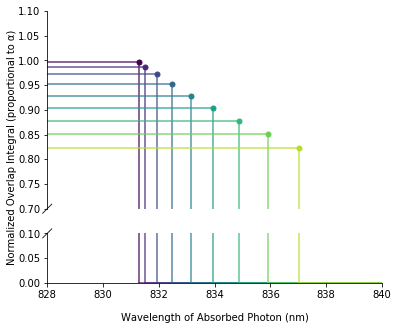

In [35]:
from brokenaxes import brokenaxes

fig = plt.figure(figsize=(6,5))
#plt.plot(np.unique(fstrengths), np.poly1d(np.polyfit(fstrengths, overlaps, 1))(np.unique(fstrengths)))
#plt.xscale("log")
#plt.yscale("log")

min_wavelength = 828
max_wavelength = 840#max(transition_energies_nm)*1.0005
min_overlap = 0.7#.8
max_overlap = 1.1

a=0.8
ax1 = brokenaxes(ylims=((0,0.1), (min_overlap, max_overlap)))

ax1.set_xlabel("Wavelength of Absorbed Photon (nm)")
ax1.set_ylabel("Normalized Overlap Integral (proportional to α)")

#breaks things
#for i in range(len(transition_energies_nm)):
#    if i == len(transition_energies_nm)-1:
#            ax1.text(transition_energies_nm[i]+0.2, overlaps[i]-0.001, pointlabels[i])
#    elif i == 0: plt.text(transition_energies_nm[i]+0.2, overlaps[i]-.001, pointlabels[i])

cmap = cm.get_cmap('viridis')
colors = []
for i in range(len(transition_energies_nm)):
    colors.append( cmap(i/len(transition_energies_nm)))

#adding boxes
for i in range(len(transition_energies_nm)):
    if i == len(transition_energies_nm)-1:
        ax1.plot([min_wavelength, transition_energies_nm[i]], [overlaps[i],overlaps[i]], c=colors[i], alpha=a)        
        rect=patches.Rectangle([min_wavelength, min_overlap], transition_energies_nm[i]-min_wavelength, overlaps[i]-min_overlap, alpha=0.1,color=colors[i])
    elif i==0:
        ax1.plot([min_wavelength, transition_energies_nm[i]], [overlaps[i],overlaps[i]], c=colors[i], alpha=a)
        rect=patches.Rectangle([min_wavelength, overlaps[i+1]], transition_energies_nm[i]-min_wavelength, overlaps[i]-overlaps[i+1], alpha=0.1,color=colors[i])        
    else:
        ax1.plot([min_wavelength, transition_energies_nm[i]], [overlaps[i],overlaps[i]], c=colors[i], alpha=a)
        rect=patches.Rectangle([min_wavelength, overlaps[i+1]], transition_energies_nm[i]-min_wavelength, overlaps[i]-overlaps[i+1], alpha=0.1,color=colors[i])
    ax1.plot([transition_energies_nm[i]]*2, [0, overlaps[i]], c=colors[i], alpha=a)
    ax1.plot([transition_energies_nm[i], max_wavelength], [0, 0], c=colors[i], alpha=a)
    ax1.plot([transition_energies_nm[i]], [overlaps[i]],linestyle='None', marker='.', markersize=10, c=colors[i])
ax1.set_xlim([min_wavelength, max_wavelength])
#ax1.set_ylim([min_overlap, max_overlap])

plt.show()

In [ ]:
# Graphing for paper figures
global m
global Efield
global e

e=-electron_charge
m=effective_hole_mass
linestyles = ['--', ':', '-.']
labels = ["1e5V/m", "1e6V/m", "1e7V/m"]

start_energies = [1e-22, 1e-22, -1e-22]
fstrengths     = [1e5, 1e6, 1e7]
x_lists        = []
psi_lists      = []


for i in range(len(fstrengths)):
    energy_eigenval = start_energies[i]
    Efield = fstrengths[i]
    opt_results = optimize_custom(energy_eigenval, energy_eigenval/4, 200)
    x_list, psi_list = psi_full(opt_results[0])
    x_lists.append(x_list)
    psi_lists.append(psi_list)

    
fig2, axes = plt.subplots(figsize=(5,4))
lines = []
for i in range(len(fstrengths)):
    line, = plt.plot(x_lists[i], psi_lists[i], c='black', linestyle=linestyles[i], label = labels[i])
    lines.append(line)

axes.set_yticks([])
axes.set_xticks([])
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
#axes.spines['bottom'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.set_xlabel("Position")
#axes.set_ylabel("Potential")

plt.legend(lines, labels)
plt.show()

In [ ]:
# Graphing for paper figures #2
global m
global Efield
global e

e=-electron_charge
m=effective_hole_mass
linestyles = ['--', '-.', ':']
labels = ["Hole Wavefunction", "Potential Well"]

energy_eigenval = -1e-22
Efield          = 1e7
x_list          = []
psi_list        = []
lines = []


opt_results = optimize_custom(energy_eigenval, energy_eigenval/4, 200)
x_list, psi_list = psi_full(opt_results[0])
print(energy_eigenval)

for i in range(len(psi_list)):
    psi_list[i] += energy_eigenval*4e25

fig2, axes = plt.subplots(figsize=(5,4))
line, = plt.plot(x_list, psi_list, c='black', label = "Hole Wavefunction")
lines.append(line)

potential_x = [x_list[0], x_list[-1]]
potential_y = [x_list[0]*Efield*e-Efield*e*well_width/2, x_list[-1]*Efield*e-Efield*e*well_width/2]
print(potential_y)

potential_y = scale_list(potential_y, 9e23)

potentialline, = plt.plot(potential_x, potential_y, c='black', linestyle='--', label = "Potential Well")
lines.append(potentialline)

#plt.plot(potential_x,[0,0],c='black',alpha=0.2)

plt.plot([0,0],[min(potential_y),max(psi_list)*1.25], c='black', linestyle='--')
plt.plot([x_list[-1],x_list[-1]],[potential_y[1],max(psi_list)*1.25], c='black', linestyle='--')


axes.set_yticks([])
axes.set_xticks([])
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
#axes.spines['bottom'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.set_xlabel("Position")
#axes.set_ylabel("Potential")

plt.legend(lines, labels,loc=1)
plt.show()

In [ ]:
#hole: 1.3414920264811964e-21 J
#electron: 9.010021073381168e-21 J

In [ ]:
# Testing with simple model of particle-in-a-box
# We know: energy eigenfunctions of a hydrogen atom are (n^2*hbar^2*pi^2)/(2*m*L^2)
# So testing with n=1, L=1e-10 E1 = 6.025e-18
# Passes test!

energy_eigenval = -1e-22

#1e7 fields
#energies = [1e7,2e7,3e7,4e7,5e7,6e7,7e7,8e7,9e7]
#hole = [-1e-22,-1e-22,-1e-21,-1e-21,-1e-20,-1e-20,-1e-20,-2e-20,-2e-20]
#electron = [1e-21,1e-21,1e-21,1e-21,1e-21,-1e-22,-1e-22,-1e-21,-1e-21]

energies = [1e6,2e6,3e6,4e6,5e6,6e6,7e6,8e6,9e6]
hole = [1e-22,1e-22,1e-22,1e-22,1e-22,1e-22,1e-22,1e-22,-1e-23]
electron = [1e-21,1e-21,1e-21,1e-21,1e-21,1e-21,1e-21,1e-21,1e-21]

global m
global Efield
global e

e=-electron_charge
m=effective_hole_mass
Efield=1e7


print("mass " + str(m))
print("efield " + str('%e'%Efield))
    
x_list, psi_list = psi_full(energy_eigenval)

print("Starting at:")
#plot_psi(x_list, psi_list)
plt.plot(x_list, psi_list, linestyle='None', marker='+')
#plt.plot([0.5e-8, 0.5e-8], [0,100000])
plt.show()

print("\n###OPTIMIZATION TESTING###")
print("custom optimization")
opt_results = optimize_custom(energy_eigenval, energy_eigenval/4, 200)
print(opt_results)
print("energy eigenval in eV " + str(opt_results[0]/1.6e-19))
x_list, psi_list = psi_full(opt_results[0])
plt.plot(x_list, psi_list)
#plt.plot([0.5e-8, 0.5e-8], [0,500])
#plt.plot(x_list, list(map((lambda x: calc_potential(x)), x_list)))
plt.show()